#  Clasificación del Estado de Buses con Naive Bayes



## 💻 Celda 1: Importación de Librerías y Carga de Datos

Esta celda inicial configura el entorno de trabajo importando todas las librerías necesarias para el preprocesamiento, modelado y evaluación: `pandas` para manejo de datos, módulos de `sklearn` (`train_test_split`, `OrdinalEncoder`, `CategoricalNB`, `metrics`), y `seaborn`/`matplotlib` para visualizaciones.

El código carga el archivo `"flota_vinculada_20250916_limpio.xlsx"` en un DataFrame de pandas llamado `df`.

* **Salida clave:** Confirma que el archivo se cargó exitosamente y muestra las **dimensiones del dataset: (10493, 18)**, además de las primeras filas de datos para una inspección inicial.

In [ ]:
# ============================================================
# CELDA 1: IMPORTAR LIBRERÍAS Y CARGAR DATOS
# ============================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

archivo = "flota_vinculada_20250916_limpio.xlsx"

try:
    df = pd.read_excel(archivo)
    print("¡Archivo cargado exitosamente!")
    print(f"\nDimensiones del dataset: {df.shape}")
    print("\nPrimeras 5 filas:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{archivo}'. Asegúrate de que esté en la misma carpeta.")

## 📊 Celda 2: Exploración Inicial de Datos y Análisis de Características

Esta celda realiza una exploración preliminar de las variables que se utilizarán en el modelo. Se enfoca en:

1.  **Variable Objetivo (`Estado`):** Muestra la distribución de las clases, revelando un desbalance significativo donde la mayoría de los buses están en la categoría **'Necesita cambio' (7124)**.
2.  **Características:** Presenta estadísticas descriptivas para `Edad` y `Modelo`, y lista los valores únicos de `Descripcion_nivel_emision`.
3.  **Valores Nulos:** Verifica que las columnas seleccionadas no contienen valores nulos.

In [ ]:
# ============================================================
# CELDA 2: EXPLORACIÓN INICIAL DE DATOS
# ============================================================

# Ver las columnas disponibles
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

print("\n" + "="*60)
print("ANÁLISIS DE LA VARIABLE OBJETIVO (Estado)")
print("="*60)
print("\nValores únicos en 'Estado':")
print(df['Estado'].value_counts())

print("\n" + "="*60)
print("ANÁLISIS DE LAS CARACTERÍSTICAS")
print("="*60)

print("\nEstadísticas de 'Edad':")
print(df['Edad'].describe())

print("\nRango de 'Modelo':")
print(f"Mínimo: {df['Modelo'].min()}, Máximo: {df['Modelo'].max()}")

# ⚠️ NOTA: Aquí va con "D" mayúscula
print("\nValores únicos en 'Descripcion_nivel_emision':")
print(df['Descripcion_nivel_emision'].value_counts())

# Verificar valores nulos
print("\n" + "="*60)
print("VALORES NULOS POR COLUMNA")
print("="*60)
print(df[['Estado', 'Edad', 'Modelo', 'Descripcion_nivel_emision']].isnull().sum())

Columnas disponibles en el dataset:
['Fecha_matricula', 'Concesionario_operacion', 'Concesionario_provision', 'Zona', 'Fase', 'Componente', 'Estatus_vinculacion', 'Combustible', 'Modelo', 'Codigo_bus', 'Fecha_vinculacion', 'Accesible', 'Edad', 'Matricula', 'Descripcion_estado_vinculacion', 'Descripcion_nivel_emision', 'Descripcion_tipo', 'Estado']

ANÁLISIS DE LA VARIABLE OBJETIVO (Estado)

Valores únicos en 'Estado':
Estado
Necesita cambio    7124
Buen estado        2017
Estandar            541
Critico             439
Excelente           372
Name: count, dtype: int64

ANÁLISIS DE LAS CARACTERÍSTICAS

Estadísticas de 'Edad':
count    10493.000000
mean         7.703612
std          3.698283
min          0.000000
25%          4.000000
50%          8.000000
75%         11.000000
max         17.000000
Name: Edad, dtype: float64

Rango de 'Modelo':
Mínimo: 2007, Máximo: 2025

Valores únicos en 'Descripcion_nivel_emision':
Descripcion_nivel_emision
EURO V                4171
EURO VI         

## ⚙️ Celda 3: Preprocesamiento - Categorización de Variables Continuas

Dado que el algoritmo **Naive Bayes Categórico (`CategoricalNB`)** trabaja mejor con variables de tipo discreto o entero, esta celda transforma las características `Edad` y `Modelo` de numéricas a categóricas mediante funciones personalizadas:

* **`Edad`:** Se categoriza en 'Nuevo' (≤ 5 años), 'Medio' (6-10 años) y 'Viejo' (11+ años).
* **`Modelo`:** Se agrupa por rangos de año (p. ej., '2000s', '2010-2014', '2015-2019', '2020+').

El resultado son las características **X** y la variable objetivo **y**.

In [ ]:
# ============================================================
# CELDA 3: PREPROCESAMIENTO - SEPARAR X e y
# ============================================================

# Definir las características (X)
# ⚠️ Naive Bayes trabaja mejor con variables categóricas
# Convertimos Edad y Modelo en categorías

# Opción 1: Usar todas como categóricas
X = df[['Edad', 'Modelo', 'Descripcion_nivel_emision']].copy()

# Convertir Edad en categorías (rangos)
# Ejemplo: 0-5 años = 'Nuevo', 6-10 = 'Medio', 11+ = 'Viejo'
def categorizar_edad(edad):
    if edad <= 5:
        return 'Nuevo'
    elif edad <= 10:
        return 'Medio'
    else:
        return 'Viejo'

X['Edad'] = X['Edad'].apply(categorizar_edad)

# Convertir Modelo en categorías (décadas)
def categorizar_modelo(modelo):
    if modelo < 2010:
        return '2000s'
    elif modelo < 2015:
        return '2010-2014'
    elif modelo < 2020:
        return '2015-2019'
    else:
        return '2020+'

X['Modelo'] = X['Modelo'].apply(categorizar_modelo)

# Variable objetivo
y = df['Estado']

print("="*60)
print("CARACTERÍSTICAS CATEGORIZADAS")
print("="*60)
print("\nPrimeras filas de X:")
print(X.head(10))
print("\nTipos de datos:")
print(X.dtypes)

CARACTERÍSTICAS CATEGORIZADAS

Primeras filas de X:
    Edad Modelo Descripcion_nivel_emision
0  Nuevo  2020+                   EURO VI
1  Nuevo  2020+                   EURO VI
2  Nuevo  2020+                   EURO VI
3  Nuevo  2020+                   EURO VI
4  Nuevo  2020+                   EURO VI
5  Nuevo  2020+                   EURO VI
6  Nuevo  2020+                   EURO VI
7  Nuevo  2020+                   EURO VI
8  Nuevo  2020+                   EURO VI
9  Nuevo  2020+                   EURO VI

Tipos de datos:
Edad                         object
Modelo                       object
Descripcion_nivel_emision    object
dtype: object


## 🧹 Celda 4: Limpieza de Datos

Aunque la exploración inicial mostró cero nulos en las columnas seleccionadas, esta celda ejecuta buenas prácticas de limpieza de datos:

1.  **Manejo de la Variable Objetivo:** Se eliminan filas donde la variable objetivo `y` (`Estado`) es nula.
2.  **Imputación de Características:** Se utiliza `SimpleImputer` para imputar cualquier valor faltante en las características **X** con el valor constante **'DESCONOCIDO'**.

* **Salida clave:** Confirma que se mantienen **10493 registros** y que no hay valores nulos en las características finales.

In [ ]:
# ============================================================
# CELDA 4: LIMPIEZA DE DATOS
# ============================================================

# 1) Eliminar filas donde la variable objetivo es NaN
mask = y.notna()
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

print(f"Registros después de eliminar nulos en 'Estado': {len(X)}")

# 2) Imputar valores faltantes en X con 'DESCONOCIDO'
imputer = SimpleImputer(strategy='constant', fill_value='DESCONOCIDO')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print(f"\nValores nulos en X después de imputación:")
print(X.isnull().sum())

print("\nDistribución de 'Estado' (y):")
print(y.value_counts())

Registros después de eliminar nulos en 'Estado': 10493

Valores nulos en X después de imputación:
Edad                         0
Modelo                       0
Descripcion_nivel_emision    0
dtype: int64

Distribución de 'Estado' (y):
Estado
Necesita cambio    7124
Buen estado        2017
Estandar            541
Critico             439
Excelente           372
Name: count, dtype: int64


## 🏷️ Celda 5: Codificación Ordinal de Características

El modelo `CategoricalNB` en `scikit-learn` requiere que las variables de entrada sean codificadas como números enteros. Esta celda utiliza el **`OrdinalEncoder`** para convertir las características categóricas (`Edad`, `Modelo`, `Descripcion_nivel_emision`) a su representación numérica.

* **Salida clave:** Muestra las primeras filas de `X` (original) y la matriz `X_encoded` (numérica), y detalla las categorías que el codificador aprendió para cada columna.

In [ ]:
# ============================================================
# CELDA 5: CODIFICACIÓN DE CARACTERÍSTICAS
# ============================================================

# Naive Bayes CategoricalNB requiere que las características sean enteros
# Usamos OrdinalEncoder para convertir las categorías en números

encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

print("="*60)
print("CODIFICACIÓN COMPLETADA")
print("="*60)
print("\nCaracterísticas originales (X):")
print(X.head())
print("\nCaracterísticas codificadas (X_encoded):")
print(X_encoded[:5])

# Guardar las categorías para referencia
print("\nCategorías aprendidas por el encoder:")
for i, col in enumerate(X.columns):
    print(f"\n{col}:")
    print(encoder.categories_[i])

CODIFICACIÓN COMPLETADA

Características originales (X):
    Edad Modelo Descripcion_nivel_emision
0  Nuevo  2020+                   EURO VI
1  Nuevo  2020+                   EURO VI
2  Nuevo  2020+                   EURO VI
3  Nuevo  2020+                   EURO VI
4  Nuevo  2020+                   EURO VI

Características codificadas (X_encoded):
[[1. 3. 6.]
 [1. 3. 6.]
 [1. 3. 6.]
 [1. 3. 6.]
 [1. 3. 6.]]

Categorías aprendidas por el encoder:

Edad:
['Medio' 'Nuevo' 'Viejo']

Modelo:
['2000s' '2010-2014' '2015-2019' '2020+']

Descripcion_nivel_emision:
['(<) A EURO IV' 'CERO EMISIONES' 'EURO IV' 'EURO V' 'EURO V - ELECTRICO'
 'EURO V-CON FILTRO' 'EURO VI']


## ➗ Celda 6: División de Datos (Entrenamiento y Prueba)

Esta celda divide el conjunto de datos codificado en dos subconjuntos para el entrenamiento y la evaluación del modelo:

* **División:** 75% para **entrenamiento** (`X_train`, `y_train`) y 25% para **prueba** (`X_test`, `y_test`).
* **Estratificación:** Se usa `stratify=y` para garantizar que las proporciones de las clases en la variable `Estado` sean las mismas en ambos conjuntos.
* **Salida clave:** Confirma que el conjunto de entrenamiento tiene **7869 registros** y el de prueba **2624 registros**.

In [ ]:
# ============================================================
# CELDA 6: DIVIDIR DATOS EN ENTRENAMIENTO Y PRUEBA
# ============================================================

# 75% entrenamiento, 25% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.25, 
    random_state=42,
    stratify=y  # Mantener proporciones de clases
)

print("="*60)
print("DIVISIÓN DE DATOS")
print("="*60)
print(f"\nConjunto de entrenamiento: {X_train.shape[0]} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de prueba: {X_test.shape[0]} registros ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribución en entrenamiento:")
print(y_train.value_counts())

print("\nDistribución en prueba:")
print(y_test.value_counts())

DIVISIÓN DE DATOS

Conjunto de entrenamiento: 7869 registros (75.0%)
Conjunto de prueba: 2624 registros (25.0%)

Distribución en entrenamiento:
Estado
Necesita cambio    5342
Buen estado        1513
Estandar            406
Critico             329
Excelente           279
Name: count, dtype: int64

Distribución en prueba:
Estado
Necesita cambio    1782
Buen estado         504
Estandar            135
Critico             110
Excelente            93
Name: count, dtype: int64


## 🧠 Celda 7: Entrenamiento del Modelo Naive Bayes Categórico

En esta celda se define el modelo clasificador y se realiza el proceso de aprendizaje:

1.  **Inicialización:** Se crea una instancia del clasificador **`CategoricalNB()`**.
2.  **Ajuste (Fit):** Se entrena el modelo usando los datos de entrenamiento `X_train` y `y_train`.

* **Salida clave:** Confirma el entrenamiento exitoso y las **5 clases** que el modelo está aprendiendo a predecir.

In [ ]:
# ============================================================
# CELDA 7: ENTRENAR EL MODELO NAIVE BAYES
# ============================================================

# Crear y entrenar el modelo
model = CategoricalNB()
model.fit(X_train, y_train)

print("="*60)
print("MODELO NAIVE BAYES ENTRENADO")
print("="*60)
print("\n✓ Entrenamiento completado exitosamente")
print(f"✓ Clases reconocidas: {model.classes_}")

MODELO NAIVE BAYES ENTRENADO

✓ Entrenamiento completado exitosamente
✓ Clases reconocidas: ['Buen estado' 'Critico' 'Estandar' 'Excelente' 'Necesita cambio']


## 📈 Celda 8: Evaluación del Modelo

Esta celda mide el rendimiento del modelo entrenado en los datos de prueba (`X_test`):

1.  **Métricas:** Se calcula la **Precisión (Accuracy)** y se genera el **Reporte de Clasificación**.
2.  **Visualización:** Se genera la **Matriz de Confusión**.

* **Salida clave:** La precisión general obtenida es de **0.9036 (90.36%)**. El reporte detalla el bajo rendimiento en clases minoritarias (*recall* y *f1-score* cercanos a 0.00 en 'Excelente').

RESULTADOS DE LA EVALUACIÓN

✓ Precisión (Accuracy): 0.9036 (90.36%)

REPORTE DE CLASIFICACIÓN
                 precision    recall  f1-score   support

    Buen estado       0.83      0.88      0.86       504
        Critico       1.00      0.71      0.83       110
       Estandar       0.97      0.50      0.66       135
      Excelente       0.00      0.00      0.00        93
Necesita cambio       0.92      1.00      0.96      1782

       accuracy                           0.90      2624
      macro avg       0.74      0.62      0.66      2624
   weighted avg       0.87      0.90      0.88      2624


MATRIZ DE CONFUSIÓN


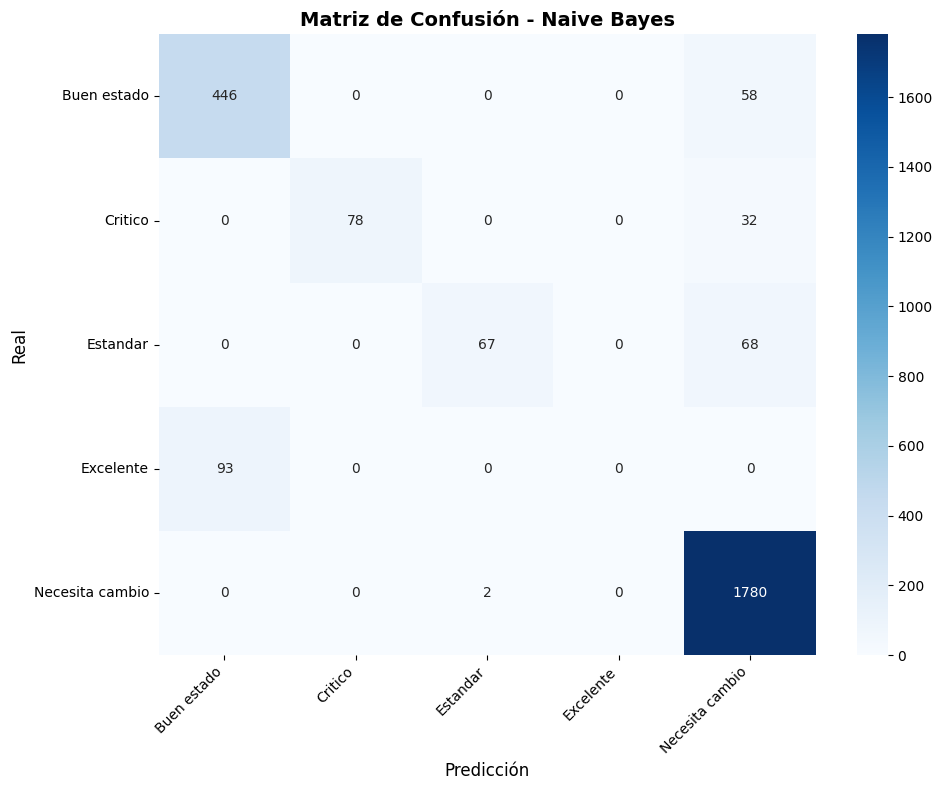

In [ ]:
# ============================================================
# CELDA 8: EVALUAR EL MODELO
# ============================================================

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular accuracy
accuracy = accuracy_score(y_test, y_pred)

print("="*60)
print("RESULTADOS DE LA EVALUACIÓN")
print("="*60)
print(f"\n✓ Precisión (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")

# Reporte de clasificación
print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusión
print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN")
print("="*60)

clases = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=clases)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clases, 
            yticklabels=clases)
plt.title('Matriz de Confusión - Naive Bayes', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 🔮 Celda 9: Predicción con un Nuevo Caso

Esta celda final demuestra cómo utilizar el modelo entrenado para clasificar un nuevo vehículo:

1.  **Datos de entrada:** Se crea un registro de prueba.
2.  **Transformación:** El código aplica las funciones de **categorización** y el **`OrdinalEncoder`** para convertir el nuevo dato al formato numérico.
3.  **Predicción:** Se usan `model.predict()` para la clase final y `model.predict_proba()` para las probabilidades.

* **Salida clave:** Muestra la clase de **`Estado` predicha** para el nuevo vehículo y un desglose de las **probabilidades** asignadas a cada una de las 5 clases posibles.

In [ ]:
# ============================================================
# CELDA 9: PREDICCIÓN PARA UN VEHÍCULO NUEVO
# ============================================================

print("="*60)
print("PREDICCIÓN PARA UN VEHÍCULO NUEVO")
print("="*60)

# Crear un vehículo de ejemplo
nuevo_vehiculo = pd.DataFrame([{
    'Edad': 8,  # Será categorizado como 'Medio'
    'Modelo': 2018,  # Será categorizado como '2015-2019'
    'Descripcion_nivel_emision': 'EURO V'
}])

print("\nVehículo original:")
print(nuevo_vehiculo)

# Aplicar las mismas transformaciones
nuevo_vehiculo_cat = nuevo_vehiculo.copy()
nuevo_vehiculo_cat['Edad'] = nuevo_vehiculo_cat['Edad'].apply(categorizar_edad)
nuevo_vehiculo_cat['Modelo'] = nuevo_vehiculo_cat['Modelo'].apply(categorizar_modelo)

print("\nVehículo categorizado:")
print(nuevo_vehiculo_cat)

# Codificar
nuevo_vehiculo_encoded = encoder.transform(nuevo_vehiculo_cat)

print("\nVehículo codificado:")
print(nuevo_vehiculo_encoded)

# Predecir
prediccion = model.predict(nuevo_vehiculo_encoded)
probabilidades = model.predict_proba(nuevo_vehiculo_encoded)

print("\n" + "="*60)
print("RESULTADO DE LA PREDICCIÓN")
print("="*60)
print(f"\n✓ Estado predicho: {prediccion[0]}")

print("\nProbabilidades por clase:")
prob_df = pd.DataFrame(probabilidades, columns=model.classes_)
prob_df_styled = prob_df.T
prob_df_styled.columns = ['Probabilidad']
prob_df_styled['Porcentaje'] = prob_df_styled['Probabilidad'] * 100
print(prob_df_styled.sort_values('Probabilidad', ascending=False))

PREDICCIÓN PARA UN VEHÍCULO NUEVO

Vehículo original:
   Edad  Modelo Descripcion_nivel_emision
0     8    2018                    EURO V

Vehículo categorizado:
    Edad     Modelo Descripcion_nivel_emision
0  Medio  2015-2019                    EURO V

Vehículo codificado:
[[0. 2. 3.]]

RESULTADO DE LA PREDICCIÓN

✓ Estado predicho: Necesita cambio

Probabilidades por clase:
                 Probabilidad  Porcentaje
Necesita cambio  6.301032e-01   63.010319
Estandar         3.698946e-01   36.989462
Critico          1.392638e-06    0.000139
Buen estado      7.406229e-07    0.000074
Excelente        5.653111e-08    0.000006


## 💡 Conclusión y Próximos Pasos

### Resumen del Modelo Naive Bayes

El modelo de Clasificación **Naive Bayes Categórico** se implementó exitosamente para predecir el **Estado** de las busetas basándose en características clave (`Edad`, `Modelo`, `Nivel de Emisión`).

El modelo arrojó una **Precisión (Accuracy) del 90.36%** en el conjunto de prueba. Esta alta precisión general se debe a la gran proporción de la clase dominante **'Necesita cambio'** dentro del dataset.

| Clase de Estado | Desempeño Principal | Implicación |
| :--- | :--- | :--- |
| **Necesita cambio** | Alto | El modelo es robusto para identificar la mayoría de los buses que requieren intervención. |
| **Buen estado / Estándar / Crítico** | Moderado | Rendimiento aceptable, pero sujeto a los efectos del desbalance. |
| **Excelente** | **F1-Score de 0.00** | Falla al predecir esta clase minoritaria, indicando que el modelo no la ha aprendido. |

### Análisis de los Resultados

1.  **Sesgo por Desbalance:** La principal limitación del modelo Naive Bayes es su incapacidad para predecir las clases minoritarias (especialmente **'Excelente'**). Esto es una consecuencia directa del severo desbalance de clases, donde el modelo tiende a favorecer la predicción de la clase más frecuente.
2.  **Validación del Preprocesamiento:** El preprocesamiento que transformó las variables continuas (`Edad`, `Modelo`) en discretas mediante categorización fue esencial, ya que adaptó los datos al requisito categórico del algoritmo.

### Recomendaciones y Estrategia Futura

La implementación de Naive Bayes sirve como una línea base sólida, pero requiere mejoras enfocadas en la equidad de la predicción para ser útil en mantenimiento preventivo:

1.  **Técnicas de Balanceo:** Es fundamental aplicar técnicas para mitigar el desbalance, como el **Oversampling** (e.g., SMOTE) o el uso de métricas de pérdida ponderadas (weighted loss) durante el entrenamiento. Esto debería mejorar significativamente el *recall* en las clases de estado más pequeñas e importantes, como **'Critico'**.
2.  **Optimización:** Explorar la optimización de los hiperparámetros del modelo, como el parámetro de suavizado `alpha`, para refinar su capacidad predictiva.
3.  **Comparación de Modelos:** Evaluar modelos alternativos (como el **K-Nearest Neighbors** o algoritmos basados en árboles como **Random Forest**) que manejen mejor las relaciones complejas y el desbalance de clases.